In [3]:
from __future__ import print_function
from __future__ import division
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import argparse
import numpy as np

import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse.linalg import spsolve


import os
import networkx as nx
import pandas as pd
data_dir = os.path.expanduser("data/cora")
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [4]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        print("Shape of parameter matrix is:",self.weight.shape)
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


In [5]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x1 = F.relu(self.gc1(x, adj))
        x2 = F.dropout(x1, self.dropout, training=self.training)
        x3 = self.gc2(x2, adj)
        x4= F.log_softmax(x3, dim=1)
        
        return x2,x4

In [6]:
from scipy.linalg import fractional_matrix_power as mat_pwr
import scipy.sparse


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="data/cora/", dataset="cora",points=None):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
#     print(features)
    
       
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    #Sandeep
    print(idx.shape)
    idx_map = {j: i for i, j in enumerate(idx)}
    #Sandeep
    #print("idx map=",idx_map)
    
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    #Sandeep
#     print("Edges=",edges.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    
    adj=adj+sp.identity(adj.shape[0])
    #Sandeep
#     print("adjshape=",adj.shape)

    features = normalize(features)
#     print("features shape=",features.shape)
    adj = normalize(adj + sp.eye(adj.shape[0]))

#     Sandeep
    D=sp.csr_matrix.sum(adj,axis=-1)
    D=np.reshape(D,(D.shape[0],))
#    
    D=np.diagflat(D)

    D_sps = sp.coo_matrix(D)
    adj_tilde=sp.csr_matrix(mat_pwr(D,-0.5)).dot(sp.csr_matrix(adj))
    adj_tilde=sp.csr_matrix(adj_tilde).dot(sp.csr_matrix(mat_pwr(D,-0.5)))

    
    
#     idx_train,idx_val,idx_test=getTrainTestIndices(points)
    idx_train = range(1)
#     idx_unlabeled = range(20,200)
    idx_val = range(1, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    
    #Sandeep
    #print("New labels=",labels[0],labels[6],labels[7])
    dense_adj=adj_tilde.todense()
    adj = sparse_mx_to_torch_sparse_tensor(adj_tilde)
    
#     print("adjacency matrix=",dense_adj[0])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
#     idx_unlabeled=torch.LongTensor(idx_unlabeled)

    return adj, features, labels, idx_train, idx_val, idx_test

#Sandeep
def inv(A):
    """
    Inverting a sparse diagonal matrix efficiently
    """
    A=sp.csr_matrix(A)
    I = sp.eye(A.shape[0], A.shape[1], dtype=A.dtype, format='csr')
    Ainv = spsolve(A, I)
    return Ainv


def get_indices_of_k_smallest(arr, k):
    """ Getting the indices of k smallest elements of an array"""
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])

#End #Sandeep

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)



In [7]:
def train(epoch):
#     print("Training...")
    t = time.time()
    model.train()
    optimizer.zero_grad()
    new_features,output = model(features, adj)

    idx_train_new=idx_train
    loss_train = F.nll_loss(output[idx_train_new], labels[idx_train_new])
    acc_train = accuracy(output[idx_train_new], labels[idx_train_new])
    loss_train.backward()
    optimizer.step()

#     

    idx_val_new=idx_val
    loss_val = F.nll_loss(output[idx_val_new], labels[idx_val_new])
    acc_val = accuracy(output[idx_val_new], labels[idx_val_new])

    return new_features


def test():
    
    model.eval()
    new_features,output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    
    return acc_test.item()

   
def selectPoints(cent_array,numPoints):
    val_array=cent_array[idx_val]
    list1, j_list2 = (list(t) for t in zip(*sorted(zip(val_array, idx_val),reverse=False)))
    tmp_val=idx_val
#     print("Max of sorted selected points=",j_list2[0])
    new_train=j_list2[:numPoints]
#     tmp_train=new_train.copy()
    new_val=[x for x in idx_val if x not in new_train]
    new_train=np.append(idx_train,new_train)
#     new_val=tmp_val
    return new_train,new_val


Loading cora dataset...
(2708,)
Shape of parameter matrix is: torch.Size([1433, 32])
Shape of parameter matrix is: torch.Size([32, 7])
Loading cora dataset...
(2708,)
Time taken to construct graph= 0.12471699714660645
Time taken to compute and list central nodes= 0.598407506942749
Time taken for training= 6.030847787857056
Test set results: loss= 0.6025 accuracy= 0.8400
Time taken between construction of graph to end of testing= 6.767899036407471
Time taken= 30.278258085250854
Time taken from making graph to end of testing= 6.767899036407471
Accuracy List= [0.84]
Mean Accuracy= 0.84
STD of Accuracy= 0.0


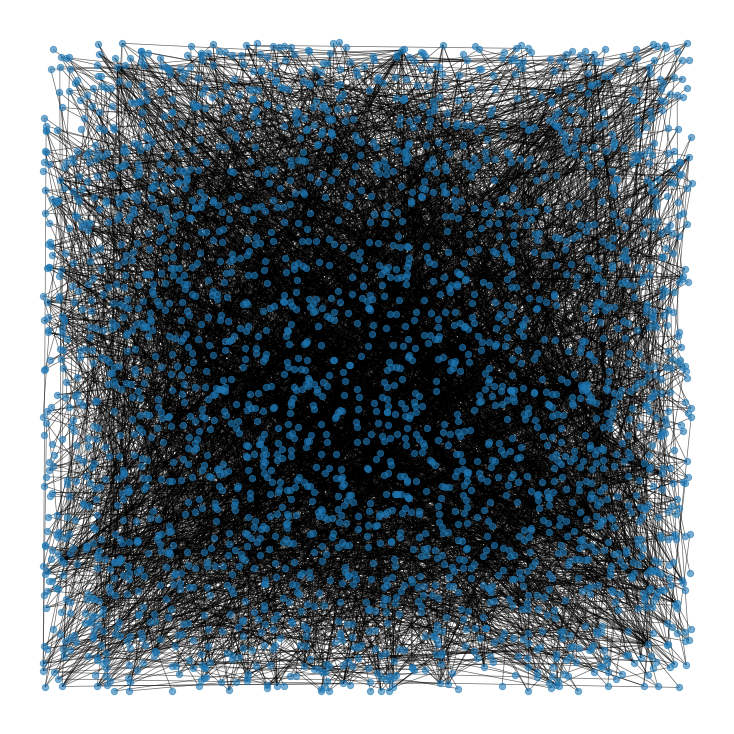

In [10]:
no_cuda=False
fastmode=False
# seed=42
epochs=500
lr=0.01
weight_decay=5e-4
hidden=32
dropout=0.5

import matplotlib.pyplot as plt

cuda = not no_cuda and torch.cuda.is_available()

# np.random.seed(seed)
# torch.manual_seed(seed)
# if cuda:
#     torch.cuda.manual_seed(seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

idx_train=idx_train.numpy()
idx_val=idx_val.numpy()
idx_test=idx_test.numpy()

# print(labels)

if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)

optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
acc_list=[]


start=time.time()
for i in range(1):
    adj, features, labels, idx_train, idx_val, idx_test = load_data()
    
    adj_np=adj.to_dense()
    adj_np=adj_np.numpy()
#     adj_np=adj_np.dot(adj_np)
    graph_start=time.time()
    D = nx.to_networkx_graph(adj_np, create_using=nx.Graph)
    graph_end=time.time()
#     print("Type of D=",type(D))
    for p in range(28):        
        cent=nx.algorithms.centrality.degree_centrality(D)
#         cent=nx.pagerank(D)
        data=list(cent.items())
        cent_array=np.array(data)
#         cent_array=np.array(cent)
        cent_array=cent_array[:,1]
#         print("Max of Cent Array=",np.argmax(cent_array))
        idx_train,idx_val=selectPoints(cent_array,5)
        e=list(idx_train)
        D.remove_nodes_from(e)
    time2=time.time()
    print("Time taken to construct graph=",graph_end-graph_start)
    print("Time taken to compute and list central nodes=",time2-graph_end)
    for epoch in range(epochs):
        new_features=train(epoch)
    train_end=time.time()
    print("Time taken for training=",train_end-time2)
#     print("Number of Training Points:",len(idx_train))
    acc=test()
    acc_list.append(acc)
end=time.time()   
print("Time taken between construction of graph to end of testing=",end-graph_start)
print("Time taken=",end-start)
print("Time taken from making graph to end of testing=",end-graph_start)
print("Accuracy List=",acc_list)
print("Mean Accuracy=",np.mean(np.asarray(acc_list)))
print("STD of Accuracy=",np.std(np.asarray(acc_list)))

D = nx.to_networkx_graph(adj_np, create_using=nx.Graph)

plt.figure(figsize=(10,10))

pos = nx.random_layout(D, seed=23)
nx.draw(D, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [81]:
#For smart selection
#Time taken= 51.40049362182617

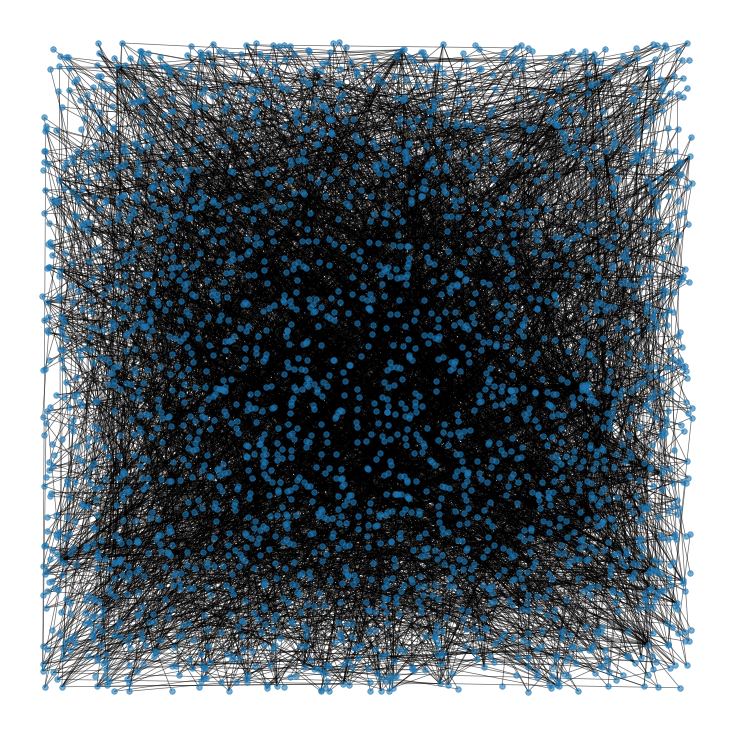

In [12]:
D = nx.to_networkx_graph(adj_np, create_using=nx.Graph)

plt.figure(figsize=(10,10))

pos = nx.random_layout(D, seed=23)
nx.draw(D, with_labels=False,  pos = pos, node_size = 30, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
acc_arr=np.asarray(acc_list)
mean=np.mean(acc_arr)
std=np.std(acc_arr)
print(mean)
print(std)

In [78]:
### Using Degree Centrality using raw graph features
#### Mean Accuracy = 0.8417999999999999
##### Std = 0.003310589071449372



0.8417999999999999
0.003310589071449372


In [35]:
import operator
from functools import reduce
import numpy as np

import collections


def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

k=range(0,10)
b=[20,30,40]
k=list(k)
k.append(b)
print(k)
flat_k=flatten(k)
print(flat_k)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, [20, 30, 40]]


C:\Users\SanVin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if __name__ == '__main__':


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 30, 40]


In [3]:
import numpy as np

a=[1,2,3,5]
for i in range(6):
    if(i in a):
        print("found",i)

found 1
found 2
found 3
found 5


In [4]:
a = (1, 11, 2)
x = sorted(a)
print(x)

[1, 2, 11]


In [47]:
import numpy as np

m1=75.1
s1=0.3
m2=76.38
s2=0.37

t=np.abs(m1-m2)/(np.sqrt((s1+s2)/9))
print(t)


4.691306663282124


In [18]:
#Cora
#1 Smart selection Degree centrality
#2 Smart selection closeness centrality
#3 Smart selection betweenness centrality
#4 AL with Degree centrality
#5 AL with Closeness centrality
#5 AL with voterank centrality
#6 Smart selection with vote rank centrality
#7 GCN SSL
#7 Smart Selection Page Rank (No significant change from GCN)
#8 AL with Page rank
#9 Applying centrality at once
#9 AL with Betweenness centrlity

In [56]:
import numpy as np

m1=67.9
s1=0.21
m2=67.2
s2=0.24

t=np.abs(m1-m2)/(np.sqrt((s1+s2)/10))
print(t)

3.2998316455372354


In [25]:
#Citeseer
#1 Smart selection Degree centrality
#1 AL with VoteRank
#2 Smart selection betweenness centrality
#2 AL with pagerank
#3 Smart selection closeness centrality
#4 Smart selection with pagerank
#4 AL with degree centrality
#4 GCN
#4 Smart selection voterank centrality
#5 Applying centrality at once 
#6 AL with closeness 
#7 AL with betweenness

In [66]:
import numpy as np

m1=76.3
s1=0.44
m2=77.2
s2=0.53

t=np.abs(m1-m2)/(np.sqrt((s1+s2)/10))
print(t)

2.889725845805728


In [33]:
#Pubmed
#1 Smart selection Degree centrality
#2 Smart selection betweenness centrality
#2 AL with degree centrality
#2 AL with voterank
#2 AL with closeness
#2 Smart selection closeness centrality
#3 Smart selection voterank centrality
#3 Smart Selection Page Rank
#3 AL with pagerank
#3 GCN
#4 Applying centrality at once 
#5 AL with betweenness

In [36]:
import numpy as np

m1=81.5
s1=0.63
m2=82.4
s2=0.06

t=np.abs(m1-m2)/(np.sqrt((s1+s2)/10))
print(t)

3.4262414443209868


In [ ]:
#CORA
#1 Smart selection Degree centrality
#2 Smart selection closeness centrality
#3 GCN

